ResNeXT 50 architecture implementation

In [1]:
import torch
import torch.nn as nn
print(torch.__version__)
print(torch.cuda.is_available())

2.1.1+cu121
True


In [2]:
class CardinalityBlock(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1, C=32):
        super(CardinalityBlock, self).__init__()
        self.expansion = 2
        self.C = C
        self.small_out_channels = out_channels // C
        self.branch = self._make_branch(in_channels, stride)
        self.identity_downsample = identity_downsample
        self.relu = nn.ReLU()

    def _make_branch(self, in_channels, stride):
        branch_layers = nn.Sequential(
            nn.Conv2d(in_channels, self.small_out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(self.small_out_channels),
            nn.Conv2d(self.small_out_channels, self.small_out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(self.small_out_channels),
            nn.Conv2d(self.small_out_channels, self.small_out_channels * self.expansion, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(self.small_out_channels * self.expansion)
        )
        return branch_layers

    def forward(self, x):
        identity = x
        branches = [self.branch(x) for _ in range(self.C)]
        x = torch.cat(branches, 1)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [3]:
class ResNeXt(nn.Module):
    def __init__(self, cardinalityBlock, num_repeat, image_channels, num_classes):
        super(ResNeXt, self).__init__()
        self.in_channels = 64
        self.initial_layers = self._init_layers(image_channels)
        self.conv2, self.conv3, self.conv4, self.conv5 = self._make_layers(cardinalityBlock, num_repeat)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024 * 2, num_classes)

    def _init_layers(self, image_channels):
        layers = nn.Sequential(
            nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        return layers

    def _make_layers(self, block, num_repeat):
        layers = []
        out_channels_list = [128, 256, 512, 1024]
        for idx, num_blocks in enumerate(num_repeat):
            stride = 1 if idx == 0 else 2
            layer = self._create_resBlock(block, num_blocks, out_channels_list[idx], stride)
            layers.append(layer)
        return layers

    def _create_resBlock(self, block, num_blocks, out_channels, stride):
        identity_downsample = None
        if self.in_channels != out_channels * 2:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 2, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * 2)
            )
        layers = [block(self.in_channels, out_channels, identity_downsample, stride)]
        self.in_channels = out_channels * 2
        layers.extend([block(self.in_channels, out_channels) for _ in range(num_blocks - 1)])
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.initial_layers(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

In [4]:
def ResNeXt50(image_channels=3, num_classes=1000):
    return ResNeXt(CardinalityBlock, [3, 4, 6, 3], image_channels, num_classes)

In [5]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [6]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size of the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loading datasets
train_data = ImageFolder(root='train', transform=transform)
val_data = ImageFolder(root='validation', transform=transform)
test_data = ImageFolder(root='test', transform=transform)

# Creating data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [7]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize the model
model = ResNeXt50()
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Adjust the number of output classes
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Using device: cuda


In [8]:
# from tqdm import tqdm

# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
#     model.to(device)
#     best_val_loss = float('inf')
#     epochs_no_improve = 0
#     best_model_state = None

#     for epoch in range(num_epochs):
#         model.train()
#         total_train_loss = 0

#         # Training loop with progress bar
#         train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} [Training]', unit='batch')
#         for inputs, labels in train_progress_bar:
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             total_train_loss += loss.item()

#         # Validation loop with progress bar
#         model.eval()
#         total_val_loss = 0
#         val_progress_bar = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} [Validation]', unit='batch')
#         with torch.no_grad():
#             for inputs, labels in val_progress_bar:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 total_val_loss += loss.item()

#         avg_train_loss = total_train_loss / len(train_loader)
#         avg_val_loss = total_val_loss / len(val_loader)

#         print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

#         # Early stopping logic
#         if avg_val_loss < best_val_loss:
#             best_val_loss = avg_val_loss
#             best_model_state = model.state_dict()
#             epochs_no_improve = 0
#         else:
#             epochs_no_improve += 1
#             if epochs_no_improve == patience:
#                 print(f'Early stopping triggered after {epoch + 1} epochs!')
#                 model.load_state_dict(best_model_state)
#                 break

#     return model

In [9]:
# New Training Function
import time
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3, save_best_model=False, verbose=True):
    model.to(device)
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.01) 

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        total_train_correct = 0
        start_time = time.time()

        # Training loop with progress bar
        train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} [Training]', unit='batch')
        for inputs, labels in train_progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_train_correct += torch.sum(preds == labels.data)

        # scheduler.step()  # Update learning rate

        # Validation loop with progress bar
        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        with torch.no_grad():
            val_progress_bar = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} [Validation]', unit='batch')
            for inputs, labels in val_progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                total_val_correct += torch.sum(preds == labels.data)

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        train_acc = total_train_correct.double() / len(train_loader.dataset)
        val_acc = total_val_correct.double() / len(val_loader.dataset)
        epoch_duration = time.time() - start_time

        if verbose:
            print(f'Epoch {epoch + 1}/{num_epochs}, Duration: {epoch_duration:.2f}s, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Early stopping and saving best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            if save_best_model:
                torch.save(model.state_dict(), 'best_model.pth')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                if verbose:
                    print(f'Early stopping triggered after {epoch + 1} epochs!')
                model.load_state_dict(best_model_state)
                break

    return model

In [10]:
num_epochs = 20  # Adjust the number of epochs as needed
patience = 5     # Adjust the patience for early stopping
save_best_model = True  # Set to True if you want to save the best model

# Call the updated train_model function with all required arguments
trained_model = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    num_epochs=num_epochs, 
    patience=patience, 
    save_best_model=save_best_model,
    verbose=True  
)

# Optionally, you can save the final trained model state as well
model_save_path = 'final_trained_model.pth'
torch.save(trained_model.state_dict(), model_save_path)
print(f'Final trained model state dictionary saved to {model_save_path}')

Epoch 1/20 [Validation]: 100%|██████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.35batch/s]


Epoch 1/20, Duration: 230.58s, Train Loss: 0.0142, Train Acc: 0.8012, Val Loss: 0.1867, Val Acc: 0.8053


Epoch 2/20 [Validation]: 100%|██████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.37batch/s]


Epoch 2/20, Duration: 229.94s, Train Loss: 0.0129, Train Acc: 0.8109, Val Loss: 0.0158, Val Acc: 0.8262


Epoch 3/20 [Validation]: 100%|██████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.20batch/s]


Epoch 3/20, Duration: 231.69s, Train Loss: 0.0122, Train Acc: 0.8226, Val Loss: 0.0200, Val Acc: 0.8105


Epoch 4/20 [Validation]: 100%|██████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.31batch/s]


Epoch 4/20, Duration: 231.55s, Train Loss: 0.0121, Train Acc: 0.8272, Val Loss: 0.0473, Val Acc: 0.8073


Epoch 5/20 [Validation]: 100%|██████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.34batch/s]


Epoch 5/20, Duration: 231.66s, Train Loss: 0.0114, Train Acc: 0.8316, Val Loss: 0.0220, Val Acc: 0.8171


Epoch 6/20 [Validation]: 100%|██████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.39batch/s]


Epoch 6/20, Duration: 233.19s, Train Loss: 0.0109, Train Acc: 0.8431, Val Loss: 0.0142, Val Acc: 0.8281


Epoch 7/20 [Validation]: 100%|██████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.34batch/s]


Epoch 7/20, Duration: 230.91s, Train Loss: 0.0105, Train Acc: 0.8499, Val Loss: 0.0225, Val Acc: 0.8125


Epoch 8/20 [Validation]: 100%|██████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.37batch/s]


Epoch 8/20, Duration: 230.04s, Train Loss: 0.0103, Train Acc: 0.8509, Val Loss: 0.0179, Val Acc: 0.8171


Epoch 9/20 [Validation]: 100%|██████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.38batch/s]


Epoch 9/20, Duration: 230.11s, Train Loss: 0.0099, Train Acc: 0.8574, Val Loss: 0.0166, Val Acc: 0.6979


Epoch 10/20 [Validation]: 100%|█████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.32batch/s]


Epoch 10/20, Duration: 231.17s, Train Loss: 0.0093, Train Acc: 0.8668, Val Loss: 0.0304, Val Acc: 0.8294


Epoch 11/20 [Validation]: 100%|█████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.38batch/s]

Epoch 11/20, Duration: 231.06s, Train Loss: 0.0128, Train Acc: 0.8657, Val Loss: 0.0157, Val Acc: 0.8177
Early stopping triggered after 11 epochs!
Final trained model state dictionary saved to final_trained_model.pth


FINAL TRAINED MODEL TESTING

In [11]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Load the model architecture
model = ResNeXt50()
model_save_path = 'final_trained_model.pth'  # Replace with your model's path
model.fc = nn.Linear(num_features, 2)

# Load the saved state dictionary
model.load_state_dict(torch.load(model_save_path, map_location=device))

# Move model to the right device and set to evaluation mode
model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

ResNeXt(
  (initial_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): CardinalityBlock(
      (branch): Sequential(
        (0): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Conv2d(4, 8, kernel_size=(1, 1), stride=(1, 1))
        (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(

In [12]:
scores = []
labels = []

with torch.no_grad():
    for inputs, target_labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        # If your model outputs logits, convert them to probabilities using sigmoid or softmax (as appropriate)
        probabilities = torch.sigmoid(outputs).cpu().numpy()
        scores.extend(probabilities)
        labels.extend(target_labels.cpu().numpy())

In [13]:
print(scores)

[array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([0.7713    , 0.23893724], dtype=float32), array([0.77699023, 0.23541984], dtype=float32), array([9.9896944e-01, 6.8245764e-04], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([0.7022996 , 0.31420422], dtype=float32), array([0.86345464, 0.14882044], dtype=float32), array([0.8634607 , 0.14308152], dtype=float32), array([9.9864703e-01, 8.4973127e-04], dtype=float32), array([0.94602466, 0.0505751 ], dtype=float32), array([1., 0.], dtype=float32), array([9.9999833e-01, 6.0673267e-07], dtype=float32), array([0.99027455, 0.0089784 ], dtype=float32), array([0.9026866 , 0.10924181], dtype=float32), array([0.9277537 , 0.07069568], dtype=float32), array([0.91981584, 0.08636203], dtype=float32), array([0.45999053, 0.5686353 ], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([0.8209296, 0.1883568], dtype=float32), array([

In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d

In [15]:
def calculate_metrics(labels, scores, far_target=1e-3):
    labels = np.array(labels)
    scores = np.array(scores)[:, 1]  # Take the probabilities of the positive class

    # Accuracy
    predictions = (scores > 0.5).astype(int)  # Using 0.5 as the threshold
    accuracy = accuracy_score(labels, predictions)

    # Calculate ROC Curve and EER
    fpr, tpr, thresholds = roc_curve(labels, scores)
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    # Find TAR at specified FAR
    far_index = np.where(fpr <= far_target)[0][-1]
    tar_at_far = tpr[far_index]

    return accuracy, eer, tar_at_far

# Calculate the metrics
accuracy, eer, tar_at_far = calculate_metrics(labels, scores)

print(f'Accuracy: {accuracy:.4f}')
print(f'EER: {eer:.4f}')
print(f'TAR at FAR={1e-3}: {tar_at_far:.4f}')

Accuracy: 0.8308
EER: 0.2178
TAR at FAR=0.001: 0.0764


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

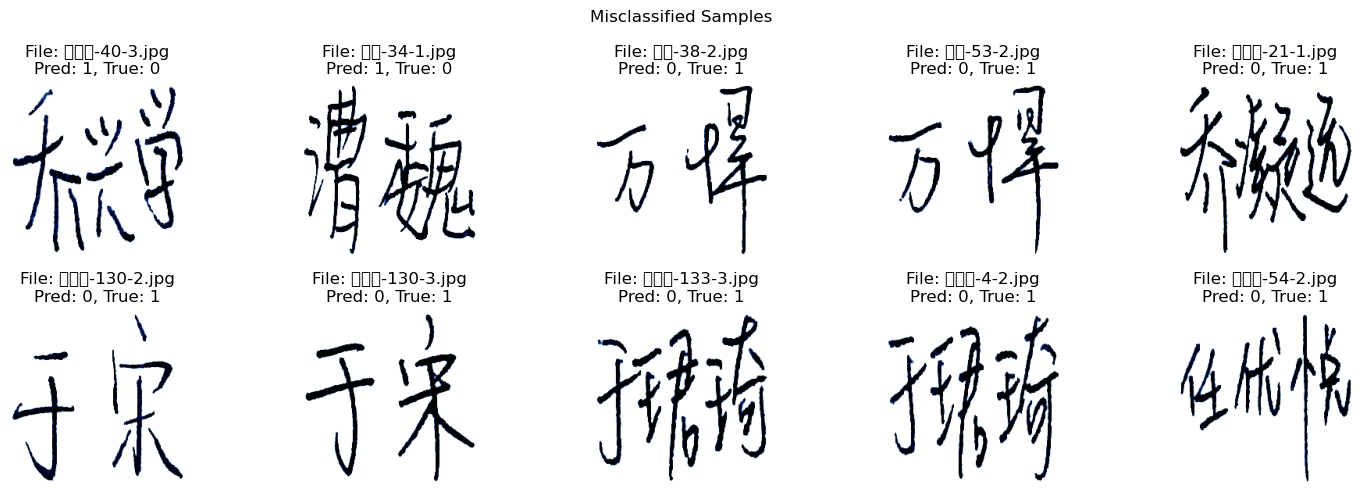

In [16]:
import matplotlib.pyplot as plt
import os

def visualize_misclassified_samples_with_filenames(data_loader, model, num_images=10, title='Misclassified Samples'):
    model.eval()
    images, predictions, true_labels, filenames = [], [], [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for input, pred, true, path in zip(inputs, preds, labels, data_loader.dataset.samples):
                if pred != true:
                    images.append(input.cpu().data)
                    predictions.append(pred.item())
                    true_labels.append(true.item())
                    filenames.append(os.path.basename(path[0]))  # Extract filename from path
                    if len(images) == num_images:
                        break
            if len(images) == num_images:
                break

    # Plotting
    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 5))
    fig.suptitle(title)
    axes = axes.flatten()
    for i, (img, pred, true, fname) in enumerate(zip(images, predictions, true_labels, filenames)):
        img = img.numpy().transpose((1, 2, 0))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'File: {fname}\nPred: {pred}, True: {true}')
    plt.tight_layout()
    plt.show()

# Call the function to visualize misclassified samples with filenames
visualize_misclassified_samples_with_filenames(test_loader, model)

In [17]:
import os

def list_misclassified_filenames(data_loader, model):
    model.eval()
    misclassified_filenames = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for pred, true, path in zip(preds, labels, data_loader.dataset.samples):
                if pred != true:
                    filename = os.path.basename(path[0])  # Extract filename from path
                    misclassified_filenames.append(filename)

    return misclassified_filenames

# Get the list of misclassified filenames
misclassified_filenames = list_misclassified_filenames(test_loader, model)

# Optionally, print the list
for filename in misclassified_filenames:
    print(filename)

乔兴学-40-3.jpg
万珆-34-1.jpg
丁会-38-2.jpg
丁会-53-2.jpg
丁景澄-21-1.jpg
丁瀚漠-130-2.jpg
丁瀚漠-130-3.jpg
丁瀚漠-133-3.jpg
丁瀚漠-4-2.jpg
万恨荷-54-2.jpg
万恨荷-68-2.jpg
万恨荷-90-1.jpg
万悍-124-3.jpg
万珆-16-3.jpg
万珆-16-4.jpg
万珆-17-3.jpg
万珆-34-5.jpg
乔兴学-40-3.jpg
乔凝远-152-1.jpg
乔凝远-152-2.jpg
于宋-18-2.jpg
于宋-18-3.jpg
于暖梦-61-1.jpg
于珺琦-70-5.jpg
于英喆-136-3.jpg
于英喆-92-2.jpg
仲长宵月-107-3.jpg
仲长宵月-22-5.jpg
丁会-107-2.jpg
丁会-107-5.jpg
丁会-38-2.jpg
丁会-53-2.jpg
丁景澄-21-1.jpg
丁瀚漠-130-2.jpg
丁瀚漠-130-3.jpg
丁瀚漠-133-3.jpg
丁瀚漠-4-2.jpg
丁瀚漠-4-5.jpg
万恨荷-54-2.jpg
万恨荷-68-2.jpg
万恨荷-90-1.jpg
万悍-124-3.jpg
万珆-16-3.jpg
万珆-17-3.jpg
乔兴学-40-3.jpg
乔凝远-152-1.jpg
乔凝远-152-2.jpg
于宋-18-2.jpg
于宋-57-4.jpg
于暖梦-61-1.jpg
于珺琦-70-5.jpg
于英喆-136-3.jpg
于英喆-92-2.jpg
仲长宵月-107-3.jpg
仲长宵月-22-3.jpg
仲长宵月-22-5.jpg
丁会-107-2.jpg
丁会-107-5.jpg
丁会-38-2.jpg
丁会-53-2.jpg
丁景澄-21-1.jpg
丁瀚漠-130-2.jpg
丁瀚漠-130-3.jpg
丁瀚漠-133-3.jpg
丁瀚漠-4-2.jpg
丁瀚漠-4-5.jpg
万恨荷-54-2.jpg
万恨荷-68-2.jpg
万恨荷-90-1.jpg
万悍-124-3.jpg
万珆-16-3.jpg
万珆-17-3.jpg
万珆-34-1.jpg
万珆-34-5.jpg
乔兴学-40-3.jpg
乔凝远-152-1.jpg
乔凝远-152-2.jpg
于

In [18]:
print(len(misclassified_filenames))

263


In [19]:
count = 0
for filename in misclassified_filenames:
    # Split the filename using '-' as a delimiter
    parts = filename.split('-')
    
    # Extract the first part of the split (i.e., the number) and convert it to an integer
    first_number = int(parts[1])
    
    # Check if the first number is greater than 100
    if first_number > 100:
        count += 1

print("Professional Signatures:", count)

Professional Signatures: 82


In [20]:
folder_path = r'C:\Mine\Work\Uzi\Signature_Verification\test\positive'

# Get the list of files in the folder
folder_files = os.listdir(folder_path)
count = 0

# Iterate through the misclassified filenames and check if they exist in the folder
for filename in misclassified_filenames:
    if filename in folder_files:
        count += 1

print("Number of misclassified Originals:", count)

Number of misclassified Originals: 0


Best Model Trained

In [21]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Load the model architecture
model = ResNeXt50()
model_save_path = 'best_model.pth'  # Replace with your model's path
model.fc = nn.Linear(num_features, 2)

# Load the saved state dictionary
model.load_state_dict(torch.load(model_save_path, map_location=device))

# Move model to the right device and set to evaluation mode
model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

ResNeXt(
  (initial_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): CardinalityBlock(
      (branch): Sequential(
        (0): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Conv2d(4, 8, kernel_size=(1, 1), stride=(1, 1))
        (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(

In [22]:
scores = []
labels = []

with torch.no_grad():
    for inputs, target_labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        # If your model outputs logits, convert them to probabilities using sigmoid or softmax (as appropriate)
        probabilities = torch.sigmoid(outputs).cpu().numpy()
        scores.extend(probabilities)
        labels.extend(target_labels.cpu().numpy())

In [23]:
print(scores)

[array([9.948913e-01, 4.020086e-04], dtype=float32), array([9.9942446e-01, 1.0716369e-05], dtype=float32), array([0.69070125, 0.3288854 ], dtype=float32), array([0.70550114, 0.31157386], dtype=float32), array([0.8634059 , 0.11953185], dtype=float32), array([1., 0.], dtype=float32), array([1.000000e+00, 3.399552e-31], dtype=float32), array([1.000000e+00, 2.999594e-29], dtype=float32), array([0.5416926 , 0.45530182], dtype=float32), array([0.84162277, 0.17433669], dtype=float32), array([0.9409588 , 0.03534425], dtype=float32), array([0.8395332 , 0.13461183], dtype=float32), array([0.92971116, 0.07669944], dtype=float32), array([1.0000000e+00, 1.5224735e-14], dtype=float32), array([9.9840111e-01, 7.5911994e-05], dtype=float32), array([9.9720216e-01, 2.1312780e-04], dtype=float32), array([0.935903  , 0.05853714], dtype=float32), array([0.9689279 , 0.01409991], dtype=float32), array([0.9713193 , 0.00950632], dtype=float32), array([0.34409952, 0.6743082 ], dtype=float32), array([1., 0.], dty

In [24]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d

In [25]:
def calculate_metrics(labels, scores, far_target=1e-3):
    labels = np.array(labels)
    scores = np.array(scores)[:, 1]  # Take the probabilities of the positive class

    # Accuracy
    predictions = (scores > 0.5).astype(int)  # Using 0.5 as the threshold
    accuracy = accuracy_score(labels, predictions)

    # Calculate ROC Curve and EER
    fpr, tpr, thresholds = roc_curve(labels, scores)
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    # Find TAR at specified FAR
    far_index = np.where(fpr <= far_target)[0][-1]
    tar_at_far = tpr[far_index]

    return accuracy, eer, tar_at_far

# Calculate the metrics
accuracy, eer, tar_at_far = calculate_metrics(labels, scores)

print(f'Accuracy: {accuracy:.4f}')
print(f'EER: {eer:.4f}')
print(f'TAR at FAR={1e-3}: {tar_at_far:.4f}')

Accuracy: 0.8373
EER: 0.2498
TAR at FAR=0.001: 0.0451


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

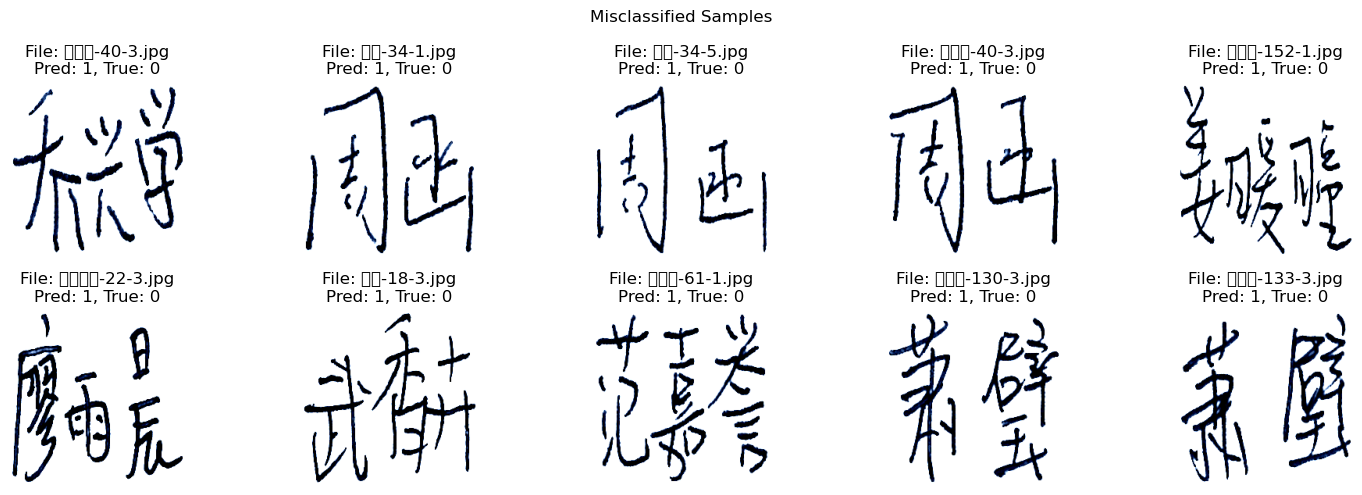

In [26]:
import matplotlib.pyplot as plt
import os

def visualize_misclassified_samples_with_filenames(data_loader, model, num_images=10, title='Misclassified Samples'):
    model.eval()
    images, predictions, true_labels, filenames = [], [], [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for input, pred, true, path in zip(inputs, preds, labels, data_loader.dataset.samples):
                if pred != true:
                    images.append(input.cpu().data)
                    predictions.append(pred.item())
                    true_labels.append(true.item())
                    filenames.append(os.path.basename(path[0]))  # Extract filename from path
                    if len(images) == num_images:
                        break
            if len(images) == num_images:
                break

    # Plotting
    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 5))
    fig.suptitle(title)
    axes = axes.flatten()
    for i, (img, pred, true, fname) in enumerate(zip(images, predictions, true_labels, filenames)):
        img = img.numpy().transpose((1, 2, 0))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'File: {fname}\nPred: {pred}, True: {true}')
    plt.tight_layout()
    plt.show()

# Call the function to visualize misclassified samples with filenames
visualize_misclassified_samples_with_filenames(test_loader, model)

In [27]:
import os

def list_misclassified_filenames(data_loader, model):
    model.eval()
    misclassified_filenames = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for pred, true, path in zip(preds, labels, data_loader.dataset.samples):
                if pred != true:
                    filename = os.path.basename(path[0])  # Extract filename from path
                    misclassified_filenames.append(filename)

    return misclassified_filenames

# Get the list of misclassified filenames
misclassified_filenames = list_misclassified_filenames(test_loader, model)

# Optionally, print the list
for filename in misclassified_filenames:
    print(filename)

乔兴学-40-3.jpg
万珆-34-1.jpg
万珆-34-5.jpg
乔兴学-40-3.jpg
乔凝远-152-1.jpg
仲长宵月-22-3.jpg
于宋-18-3.jpg
于暖梦-61-1.jpg
丁瀚漠-130-3.jpg
丁瀚漠-133-3.jpg
万恨荷-90-1.jpg
万悍-124-3.jpg
万珆-16-3.jpg
丁会-107-5.jpg
丁瀚漠-4-2.jpg
于英喆-136-3.jpg
丁会-107-5.jpg
丁会-38-2.jpg
丁会-53-2.jpg
丁景澄-21-1.jpg
丁瀚漠-133-3.jpg
丁瀚漠-4-2.jpg
万恨荷-54-2.jpg
万恨荷-68-2.jpg
万恨荷-90-1.jpg
万悍-124-3.jpg
万珆-16-3.jpg
万珆-16-4.jpg
万珆-17-3.jpg
乔兴学-40-3.jpg
乔凝远-152-1.jpg
乔凝远-152-2.jpg
于宋-18-2.jpg
于暖梦-61-1.jpg
于珺琦-70-5.jpg
于英喆-136-3.jpg
仲长宵月-107-3.jpg
仲长宵月-22-5.jpg
丁会-107-2.jpg
丁会-107-5.jpg
丁会-38-2.jpg
丁会-53-2.jpg
丁景澄-21-1.jpg
丁瀚漠-130-2.jpg
丁瀚漠-130-3.jpg
丁瀚漠-133-3.jpg
丁瀚漠-4-2.jpg
丁瀚漠-4-5.jpg
万恨荷-54-2.jpg
万恨荷-68-2.jpg
万恨荷-90-1.jpg
万悍-124-3.jpg
万珆-16-3.jpg
万珆-17-3.jpg
万珆-34-5.jpg
乔兴学-40-3.jpg
乔凝远-152-1.jpg
乔凝远-152-2.jpg
于宋-18-2.jpg
于宋-57-4.jpg
于暖梦-61-1.jpg
于珺琦-70-5.jpg
于英喆-136-3.jpg
于英喆-92-2.jpg
仲长宵月-22-3.jpg
仲长宵月-22-5.jpg
丁会-107-2.jpg
丁会-107-5.jpg
丁会-38-2.jpg
丁会-53-2.jpg
丁景澄-21-1.jpg
丁瀚漠-130-2.jpg
丁瀚漠-130-3.jpg
丁瀚漠-133-3.jpg
丁瀚漠-4-2.jpg
丁瀚漠-4-5.jpg
万恨荷-54-2.jpg
万

In [28]:
print(len(misclassified_filenames))

250


In [29]:
count = 0
for filename in misclassified_filenames:
    # Split the filename using '-' as a delimiter
    parts = filename.split('-')
    
    # Extract the first part of the split (i.e., the number) and convert it to an integer
    first_number = int(parts[1])
    
    # Check if the first number is greater than 100
    if first_number > 100:
        count += 1

print("Professional Signatures:", count)

Professional Signatures: 81


In [30]:
folder_path = r'C:\Mine\Work\Uzi\Signature_Verification\test\positive'

# Get the list of files in the folder
folder_files = os.listdir(folder_path)
count = 0

# Iterate through the misclassified filenames and check if they exist in the folder
for filename in misclassified_filenames:
    if filename in folder_files:
        count += 1

print("Number of misclassified Originals:", count)

Number of misclassified Originals: 0
